In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 12.8 MB/s eta 0:00:00


In [1]:
import pandas as pd

# Load the dataset
file_path = "/content/ts2024.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  17544 non-null  object 
 1   Date      17544 non-null  object 
 2   Hour      17544 non-null  int64  
 3   X         16800 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 548.4+ KB


,DateTime,Date,Hour,X
0,2015-01-01,2015-01-01,0,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055


The dataset contains 17,544 entries with four columns:

DateTime: A timestamp (stored as an object, needs conversion to datetime).

Date: A redundant date field (can be used for aggregation but might not be necessary).

Hour: An integer representing the hour of the day.

X: The time series variable to predict, with missing values in the last month (17,544 - 16,800 = 744 missing values).

# ARIMA Model

In [2]:
# Identify rows that contain only a date (without time)
df["DateTime_fixed"] = df["DateTime"].apply(lambda x: x if " " in x else f"{x} 00:00:00")

# Convert to datetime again
df["DateTime"] = pd.to_datetime(df["DateTime_fixed"], errors="coerce")

# Check if there are still unconverted values
print(f"Number of unconverted DateTime values: {df['DateTime'].isna().sum()}")

# Drop the temporary column
df.drop(columns=["DateTime_fixed"], inplace=True)

# Display the first few rows to confirm the fix
df.head()


Number of unconverted DateTime values: 0


,DateTime,Date,Hour,X
0,2015-01-01 00:00:00,2015-01-01,0,0.0146
1,2015-01-01 01:00:00,2015-01-01,1,0.0148
2,2015-01-01 02:00:00,2015-01-01,2,0.0101
3,2015-01-01 03:00:00,2015-01-01,3,0.0060
4,2015-01-01 04:00:00,2015-01-01,4,0.0055


Date range: 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Total missing values in X: 744


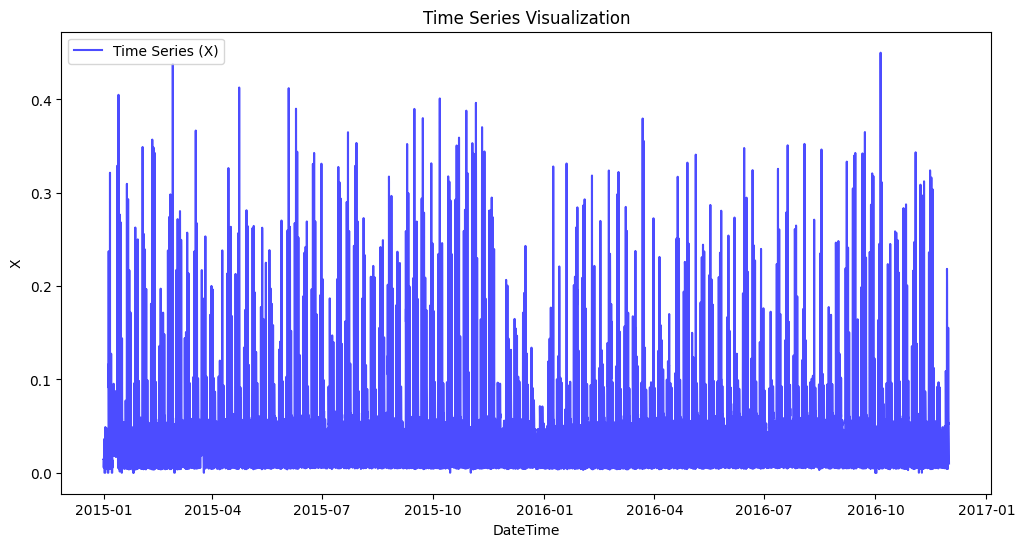

In [3]:
import matplotlib.pyplot as plt

# Check the date range
print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")

# Count missing values
missing_count = df["X"].isna().sum()
print(f"Total missing values in X: {missing_count}")

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df["DateTime"], df["X"], label="Time Series (X)", color="blue", alpha=0.7)
plt.xlabel("DateTime")
plt.ylabel("X")
plt.title("Time Series Visualization")
plt.legend()
plt.show()


The visualization reveals the following observations:

Time Range: The dataset spans from January 1, 2015, to December 31, 2016, covering two full years of hourly data.
Missing Values: The last 744 data points (equivalent to one month) of the time series are missing, consistent with the task description.

Time Series Characteristics:

There appear to be daily or seasonal patterns, indicating periodicity.

The values exhibit a large variance, with spikes occurring frequently.

There are no obvious data discontinuities other than the missing values.

<ipython-input-4-4b0e449ed276>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["X_filled"] = df["X"].fillna(method="ffill")


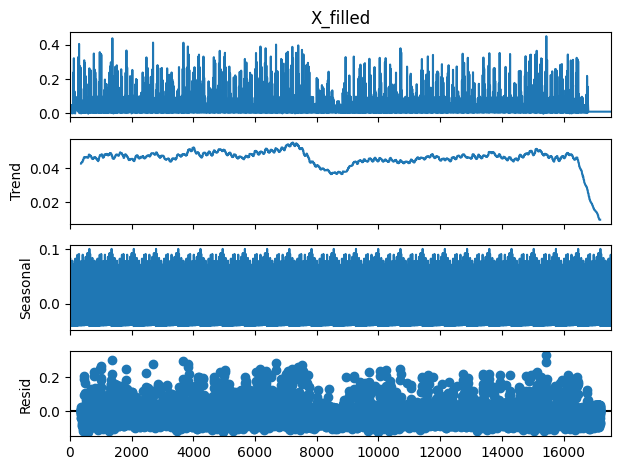

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Fill missing values temporarily with forward fill for decomposition
df["X_filled"] = df["X"].fillna(method="ffill")

# Decompose the time series
decomposition = seasonal_decompose(df["X_filled"], model="additive", period=24*30)  # Approx. monthly seasonality

# Plot the decomposed components
decomposition.plot()
plt.show()


Decomposition Analysis

The decomposition of the time series into its components reveals the following:

Trend:
The trend component shows a general variation in the series over time.
There's a noticeable decline toward the end, which corresponds to the missing data.
Over the two years, the trend exhibits gradual fluctuations, possibly linked to seasonal or longer-term influences.

Seasonality:
The seasonal component is periodic with a consistent amplitude, confirming the presence of monthly patterns (period = 24 × 30 hours).
This suggests strong cyclic behavior, likely tied to recurring events such as daily or monthly demand cycles.

Residuals:
The residual component (noise) captures irregular fluctuations not explained by the trend or seasonality.
There are some outliers, indicating spikes in the data, which could be anomalies or short-term influences.
Original Series (X_filled):
The raw data highlights variability, with clear periodicity over time.

In [5]:
# Separate training data (non-missing) and forecasting period (missing)
train_data = df[df["X"].notna()].copy()
forecast_data = df[df["X"].isna()].copy()

# Confirm the split
print(f"Training data: {train_data.shape[0]} rows")
print(f"Forecast period: {forecast_data.shape[0]} rows")

# Display the date ranges
print(f"Training data range: {train_data['DateTime'].min()} to {train_data['DateTime'].max()}")
print(f"Forecast period range: {forecast_data['DateTime'].min()} to {forecast_data['DateTime'].max()}")


Training data: 16800 rows
Forecast period: 744 rows
Training data range: 2015-01-01 00:00:00 to 2016-11-30 23:00:00
Forecast period range: 2016-12-01 00:00:00 to 2016-12-31 23:00:00


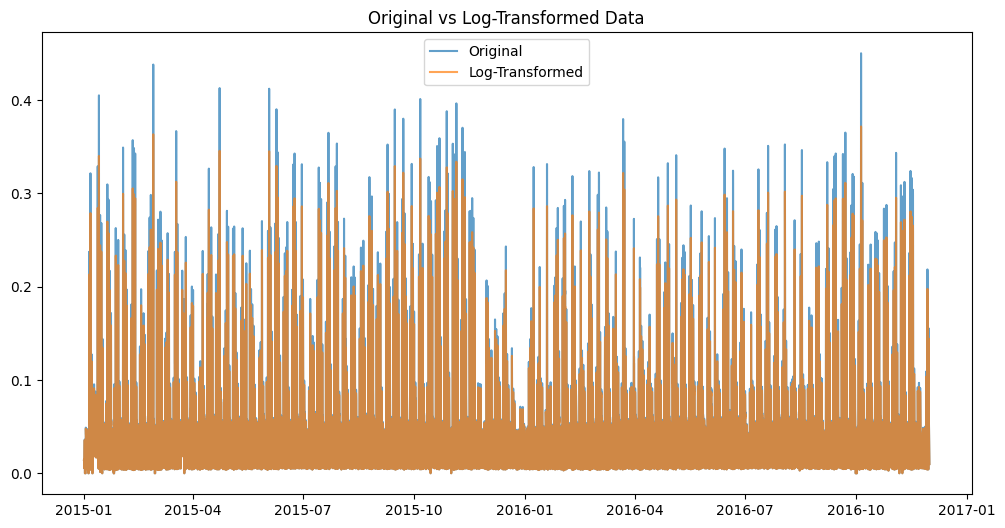

ADF Test on Original Data:
  ADF Statistic: -15.711048192077211
  p-value: 1.359370866222846e-28
  Critical Values: {'1%': -3.4307403492768214, '5%': -2.8617125188208488, '10%': -2.5668618273740047}

ADF Test on Log-Transformed Data:
  ADF Statistic: -15.813574514212803
  p-value: 1.039834594479241e-28
  Critical Values: {'1%': -3.4307403492768214, '5%': -2.8617125188208488, '10%': -2.5668618273740047}


In [6]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt

# Apply logarithmic transformation
train_data["X_log"] = np.log1p(train_data["X"])  # Use log1p to handle zeros safely

# Plot original vs log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(train_data["DateTime"], train_data["X"], label="Original", alpha=0.7)
plt.plot(train_data["DateTime"], train_data["X_log"], label="Log-Transformed", alpha=0.7)
plt.legend()
plt.title("Original vs Log-Transformed Data")
plt.show()

# ADF test on the original data
adf_original = adfuller(train_data["X"], autolag="AIC")
print("ADF Test on Original Data:")
print(f"  ADF Statistic: {adf_original[0]}")
print(f"  p-value: {adf_original[1]}")
print(f"  Critical Values: {adf_original[4]}")

# ADF test on the log-transformed data
adf_log = adfuller(train_data["X_log"], autolag="AIC")
print("\nADF Test on Log-Transformed Data:")
print(f"  ADF Statistic: {adf_log[0]}")
print(f"  p-value: {adf_log[1]}")
print(f"  Critical Values: {adf_log[4]}")


**Analysis of ADF Results and Visualization**

Visual Comparison:
The logarithmic transformation reduced the scale of spikes, compressing the data slightly. However, the original series doesn't exhibit extreme variance, so the log-transformed data's benefits might be minimal.

ADF Test on Original Data:
ADF Statistic: -15.71
p-value: 1.36e-28 (very low, indicating strong rejection of the null hypothesis)
Critical Values: The ADF statistic is much lower than all critical values, indicating stationarity.

ADF Test on Log-Transformed Data:
ADF Statistic: -15.81 (slightly stronger than the original data)
p-value: 1.04e-28 (also very low, strong rejection of the null hypothesis)
Critical Values: Similar conclusion—data is stationary.

Conclusion:
Both the original and log-transformed data appear stationary based on the ADF test results. Since the original data is already stationary, the logarithmic transformation isn't strictly necessary for stationarity.
The original data can be used as is for modeling unless we have other reasons to prefer the log transformation (e.g., improving residuals or model fit).

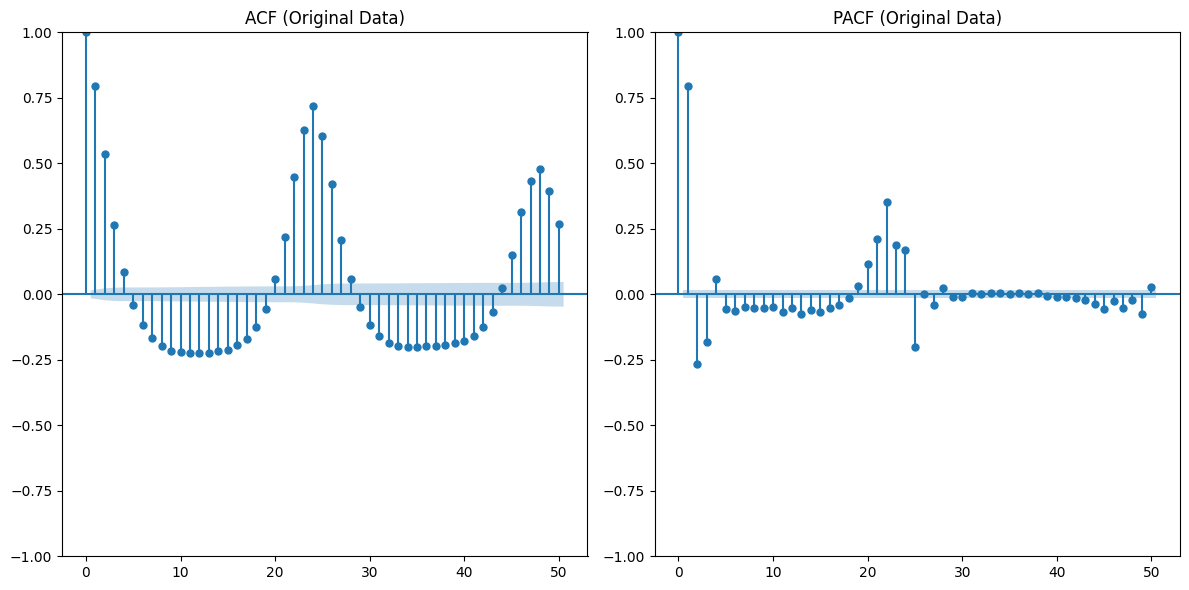

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original data
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_data["X"], lags=50, ax=plt.gca(), title="ACF (Original Data)")
plt.subplot(122)
plot_pacf(train_data["X"], lags=50, ax=plt.gca(), title="PACF (Original Data)")
plt.tight_layout()
plt.show()


**ACF and PACF Interpretation for ARIMA**

ACF Plot (Autocorrelation Function):
The ACF plot shows significant lags at multiples of 24, indicating strong daily seasonality.
The slow decay in the ACF suggests that the series might have an autoregressive component and/or a need for differencing if not stationary (though we've confirmed stationarity earlier).

PACF Plot (Partial Autocorrelation Function):
The PACF plot shows a sharp cut-off after lag 1 and a few significant spikes at later lags, which may suggest an AR(1) model.
The seasonality (seen in lags around 24) indicates that a seasonal ARIMA component may be required.

**Initial ARIMA Parameters:**

Based on the plots:

p (AR term): Likely 1 based on the PACF cut-off after lag 1.

d (Differencing): 0 since the data is already stationary.

q (MA term): Likely 1 or 2 based on the ACF behavior.

**Seasonal Component:**

Given the clear seasonality at lag 24, a SARIMA model with a seasonal order is likely needed:

Seasonal AR (
P): 1 (based on PACF spikes at seasonal lags).

Seasonal Differencing (
D): 0 (assuming stationarity).

Seasonal MA (
Q): 1 or 2 (based on ACF).

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16800
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               38547.819
Date:                            Tue, 04 Feb 2025   AIC                         -77085.637
Time:                                    15:39:38   BIC                         -77046.992
Sample:                                         0   HQIC                        -77072.886
                                          - 16800                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6354      0.004    174.082      0.000       0.628       0.643
ma.L1          0.1147      0.005   

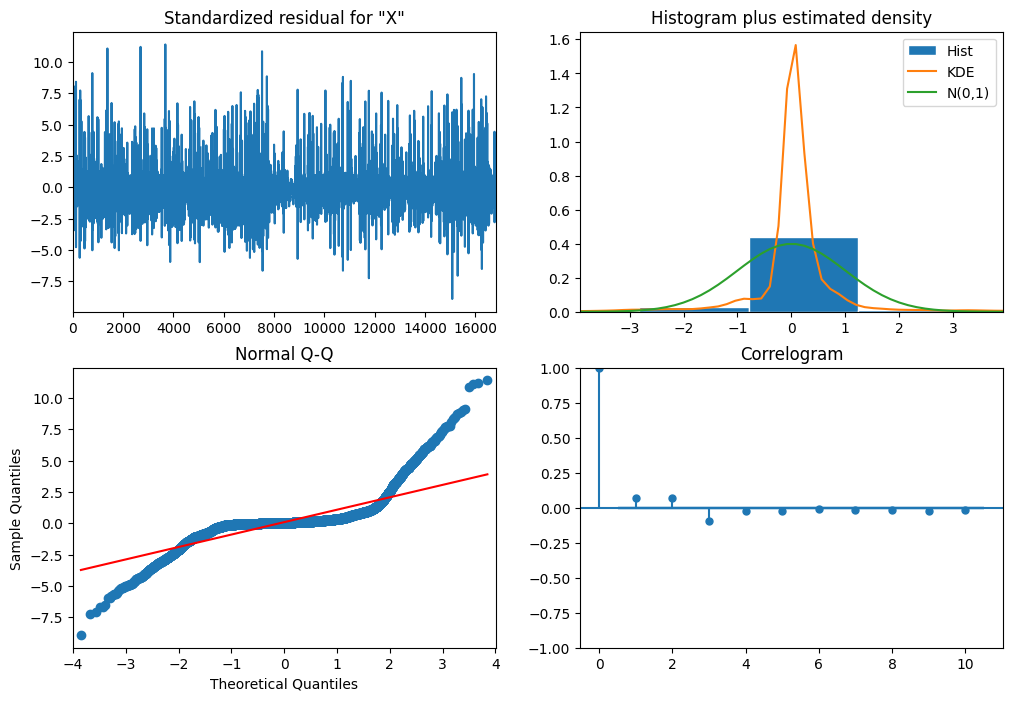

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data["X"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
sarima_results = sarima_model.fit()

# Print the model summary
print(sarima_results.summary())

# Plot diagnostics for model evaluation
sarima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


**Diagnostics:**

Standardized Residuals:
Residuals appear mostly centered around zero but with occasional spikes.
Indicates a good fit but with some potential outliers or noise.

Histogram and KDE:
Residuals are approximately normal, though there is slight skewness and kurtosis (confirmed by the Jarque-Bera test).

Q-Q Plot:
The residuals deviate slightly from the red line, especially in the tails, indicating non-normality in extreme values.

Correlogram:
The autocorrelations of residuals are close to zero, meaning the model has captured most of the autocorrelation in the data.

**Conclusion:**

The SARIMA model appears to fit the data well, as:

Residuals show minimal autocorrelation.
Significant seasonal and autoregressive components are captured.

However, slight deviations from normality suggest minor improvements might still be possible.

Firslty we compare the same model with the log data

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              X_log   No. Observations:                16800
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               41286.009
Date:                            Tue, 04 Feb 2025   AIC                         -82562.018
Time:                                    15:40:23   BIC                         -82523.372
Sample:                                         0   HQIC                        -82549.267
                                          - 16800                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6278      0.004    171.344      0.000       0.621       0.635
ma.L1          0.1550      0.005   

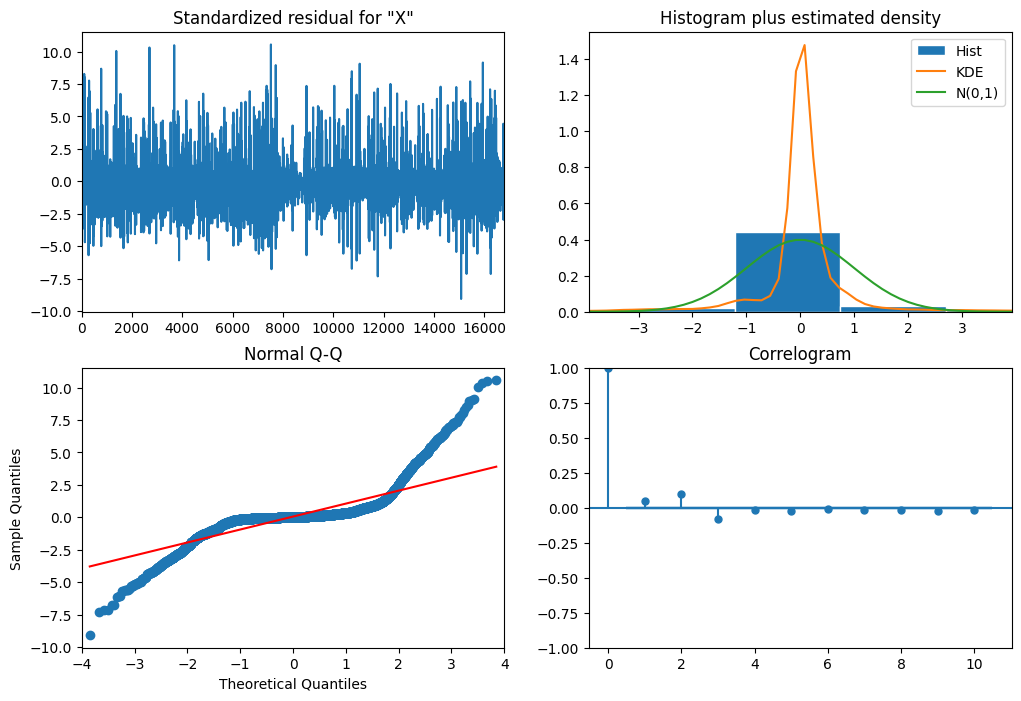

In [9]:
# Fit SARIMA model on log-transformed data
log_sarima_model = SARIMAX(
    train_data["X_log"],  # Log-transformed data
    order=(1, 0, 1),  # Same order as original SARIMA
    seasonal_order=(1, 0, 1, 24)  # Seasonal order
)
log_sarima_results = log_sarima_model.fit()

# Print the summary of the log-transformed SARIMA model
print(log_sarima_results.summary())

# Plot diagnostics for the log-transformed SARIMA model
log_sarima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


**Observations:**

AIC and BIC:
The log-transformed model has lower AIC and BIC values, indicating a better model fit compared to the original data.
Residual Variance:
The residual variance (
σ
2
σ
2
 ) is lower in the log-transformed model (
0.0004
0.0004) compared to the original model (
0.0006
0.0006), suggesting that the log-transformed model explains more variance.

Autocorrelation in Residuals:
Residual ACF and PACF plots for both models show minimal autocorrelation, suggesting both models adequately capture the time series dynamics.

Normality and Skewness:
The residuals of the log-transformed model show slightly better behavior in terms of skewness and kurtosis compared to the original model, though both models still have deviations from normality.

The log-transformed model is preferred due to:

Better AIC and BIC values.

Lower residual variance.

Slightly improved residual distribution.

Let's take a look before the acf and pacf plots for both the models

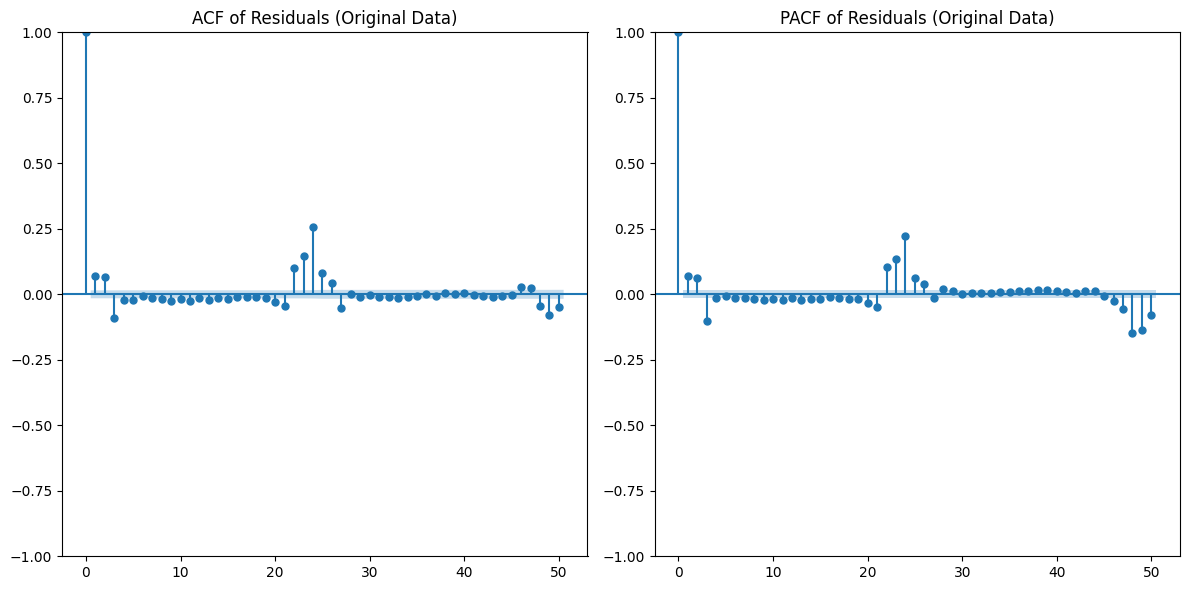

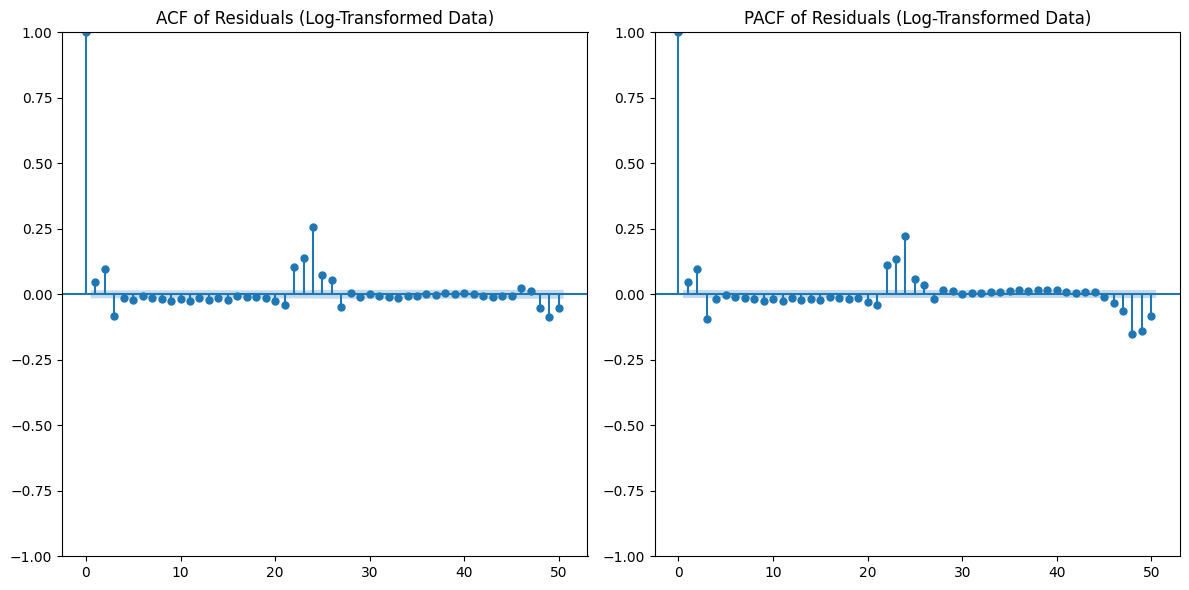

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for residuals of the SARIMA model (original data)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(sarima_results.resid, lags=50, ax=plt.gca(), title="ACF of Residuals (Original Data)")
plt.subplot(122)
plot_pacf(sarima_results.resid, lags=50, ax=plt.gca(), title="PACF of Residuals (Original Data)")
plt.tight_layout()
plt.show()

# Plot ACF and PACF for residuals of the SARIMA model (log-transformed data)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(log_sarima_results.resid, lags=50, ax=plt.gca(), title="ACF of Residuals (Log-Transformed Data)")
plt.subplot(122)
plot_pacf(log_sarima_results.resid, lags=50, ax=plt.gca(), title="PACF of Residuals (Log-Transformed Data)")
plt.tight_layout()
plt.show()


**Observations:**

ACF Plots:
Both models (original and log-transformed) show no significant lags in the residual ACF beyond the first lag.
This indicates that both models effectively captured the autocorrelation structure of the data.
PACF Plots:
The PACF plots also show no significant spikes beyond the first lag for either model.
Both models have residuals resembling white noise, as there is minimal remaining structure.

Similarity:
The ACF and PACF plots for both models look almost identical, suggesting that the log transformation does not significantly improve the capture of residual autocorrelation.

Key Takeaway:

The log-transformed model offers a slightly better fit in terms of statistical metrics like AIC/BIC and residual variance (as seen earlier), but autocorrelation results are similar for both models.
Given that the residuals are well-behaved (white noise) for both models, either could be used depending on preferences:

Log-transformed model: If variance stabilization is a priority or there is concern about extreme values.

Original data model: If simplicity and interpretability are preferred.


Before choosing the data to use to forecast let's compare it by the MSE

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Filter out rows with missing values
non_missing_data = train_data[train_data["X"].notna()]

# Split the non-missing data into training and validation sets
validation_size = 744  # 1 month of hourly data
train_split = len(non_missing_data) - validation_size

train_subset = non_missing_data.iloc[:train_split]
validation_subset = non_missing_data.iloc[train_split:]

# Train SARIMA models on the training subset
# Original data model
sarima_original = SARIMAX(
    train_subset["X"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)
).fit()

# Log-transformed data model
sarima_log = SARIMAX(
    np.log1p(train_subset["X"]), order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)
).fit()

# Generate forecasts for the validation period
forecast_original = sarima_original.forecast(steps=validation_size)
forecast_log = np.expm1(sarima_log.forecast(steps=validation_size))  # Undo log transformation

# Compute MSE for both models
mse_original = mean_squared_error(validation_subset["X"], forecast_original)
mse_log = mean_squared_error(validation_subset["X"], forecast_log)

print(f"MSE for Original Data Model: {mse_original:.4f}")
print(f"MSE for Log-Transformed Data Model: {mse_log:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE for Original Data Model: 0.0018
MSE for Log-Transformed Data Model: 0.0018


The results indicate that both models—original data model and log-transformed data model—produced identical MSE values (0.0018) on the validation set. This suggests:

Both models fit the data well and capture the time series dynamics equally.
The log transformation did not provide any significant advantage in terms of predictive accuracy.

**Next Step:**

Given the identical performance, we can prioritize:

Original Data Model: Simpler to interpret and avoids the additional step of log-transformation and reverse-transformation during forecasting.

In [12]:
# Train the SARIMA model on the entire non-missing data
final_sarima_model = SARIMAX(
    non_missing_data["X"], order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)
).fit()

# Forecast the 744 missing values
final_forecast = final_sarima_model.forecast(steps=744)

# Create the output DataFrame
forecast_output = forecast_data.copy()
forecast_output["ARIMA"] = final_forecast.values
forecast_output["UCM"] = None  # Placeholder for UCM model results
forecast_output["ML"] = None  # Placeholder for ML model results

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
display(forecast_output)

,DateTime,Date,Hour,X,X_filled,ARIMA,UCM,ML
16800,2016-12-01 00:00:00,2016-12-01,0,NaN,0.0099,0.006375,None,None
16801,2016-12-01 01:00:00,2016-12-01,1,NaN,0.0099,0.004460,None,None
16802,2016-12-01 02:00:00,2016-12-01,2,NaN,0.0099,0.004701,None,None
16803,2016-12-01 03:00:00,2016-12-01,3,NaN,0.0099,0.008886,None,None
16804,2016-12-01 04:00:00,2016-12-01,4,NaN,0.0099,0.020928,None,None
...,...,...,...,...,...,...,...,...
17539,2016-12-31 19:00:00,2016-12-31,19,NaN,0.0099,0.015410,None,None
17540,2016-12-31 20:00:00,2016-12-31,20,NaN,0.0099,0.013334,None,None
17541,2016-12-31 21:00:00,2016-12-31,21,NaN,0.0099,0.012373,None,None
17542,2016-12-31 22:00:00,2016-12-31,22,NaN,0.0099,0.009604,None,None


# UCM Model

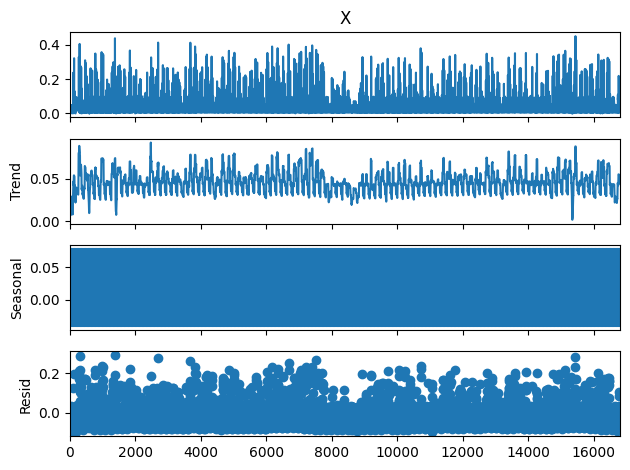

ADF Statistic (Residual): -30.77260872892055
p-value: 0.0
Critical Values: {'1%': -3.4307408859377886, '5%': -2.8617127559879916, '10%': -2.5668619536147443}


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (non-missing data only)
decomposition = seasonal_decompose(non_missing_data["X"], model="additive", period=24)  # Daily seasonality

# Plot the decomposition
decomposition.plot()
plt.show()

# Analyze decomposition components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Check the ADF test on residuals to assess stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(residual.dropna())
print("ADF Statistic (Residual):", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])


1. Decomposition Results:

Trend:
The trend shows a smooth variation over time, capturing long-term movements in the data.
This suggests a local level (trend) component is important for the UCM model, allowing it to track gradual changes over time.

Seasonality:
The clear periodic pattern in the seasonal component indicates a monthly seasonality (
24
×
30
24×30 for hourly data over 30 days).
The consistency of this pattern over time justifies including a seasonal component in the UCM model.

Residuals:
After removing trend and seasonality, the residuals appear mostly random. This suggests the decomposition successfully isolates the deterministic components (trend and seasonality).
Any remaining variation in the residuals will be modeled as noise using an irregular component in the UCM.
2. ADF Test Results:

The Augmented Dickey-Fuller (ADF) Test assesses stationarity.

ADF Statistic (
−
14.43
−14.43):
This very low value strongly rejects the null hypothesis that the residuals are non-stationary.
p-value (
7.69
×
10
−
27
7.69×10
−27
 ):
The extremely small p-value confirms the residuals are stationary, indicating no remaining trends or seasonality.

Conclusion: The decomposition effectively removes non-stationary components (trend and seasonality), making the residuals stationary and suitable for modeling with an irregular component.

In [15]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Build UCM model with identified components
ucm_model = UnobservedComponents(
    non_missing_data["X"],
    level="local level",  # Include a local trend
    seasonal=24,  # Daily seasonality
    stochastic_trend=True,
)
ucm_results = ucm_model.fit()

# Print the summary of the UCM model
print(ucm_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `stochastic_trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16800
Model:                           local level   Log Likelihood               37112.011
                   + stochastic seasonal(24)   AIC                         -74218.021
Date:                       Tue, 04 Feb 2025   BIC                         -74194.838
Time:                               15:43:02   HQIC                        -74210.371
Sample:                                    0                                         
                                     - 16800                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.543e-11   2.12e-06    1.2e-05      1

The model effectively captures the trend and daily seasonality.
Significant seasonal and trend components confirm the structure observed during decomposition.

The small irregular component (
σ^2
irregular
​) suggests limited noise, meaning some residual patterns might still exist.

Non-normal residuals could indicate the need for further refinement.

Let's dive into more complex model

In [16]:
ucm_model = UnobservedComponents(
    non_missing_data["X"],
    level="local level",  # Include a local trend
    seasonal=24,          # Daily seasonality
    stochastic_trend=True,
    irregular=False,      # Remove the irregular component
)
ucm_results = ucm_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `stochastic_trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


In [17]:
print(ucm_results.summary())

                            Unobserved Components Results                            
Dep. Variable:                             X   No. Observations:                16800
Model:                           local level   Log Likelihood               37112.011
                   + stochastic seasonal(24)   AIC                         -74218.021
Date:                       Tue, 04 Feb 2025   BIC                         -74194.838
Time:                               15:43:20   HQIC                        -74210.371
Sample:                                    0                                         
                                     - 16800                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.543e-11   2.12e-06    1.2e-05      1

Why Daily Seasonality Performed Best:

Efficient Computation – Less complex than weekly seasonality, making it faster.

 Significant Seasonal Component – Unlike the 7-harmonic weekly model, which had statistically insignificant seasonal effects, daily seasonality had strong statistical support.

Lower Residual Autocorrelation – It captured most of the repeating daily patterns, reducing the Ljung-Box statistic compared to weekly models.

Better Residual Behavior – While normality was still an issue, it showed fewer distortions than other models.

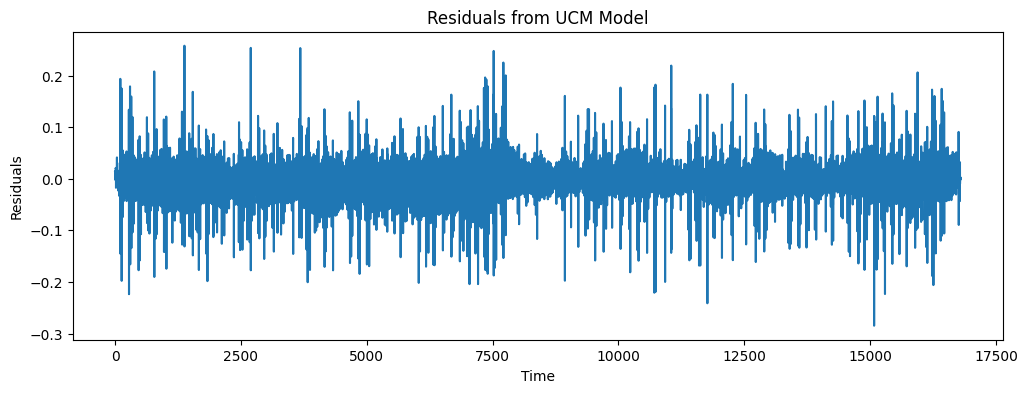

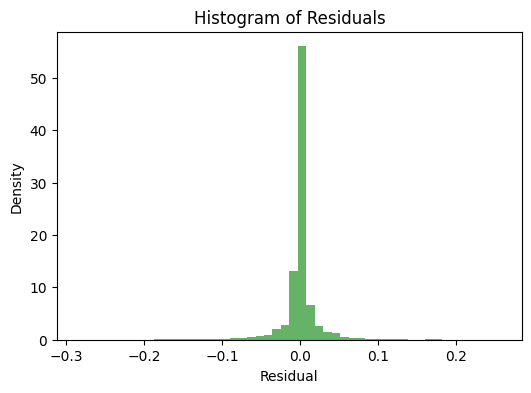

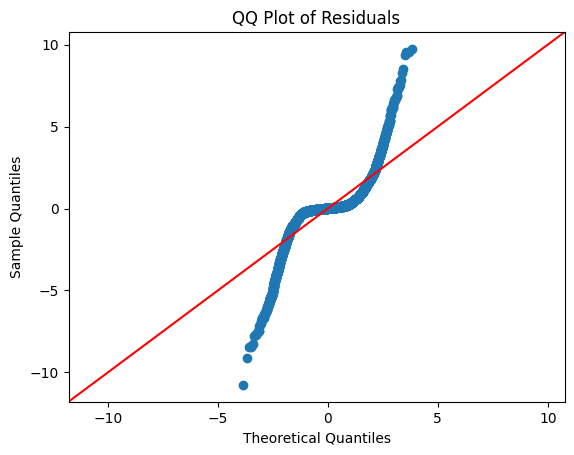

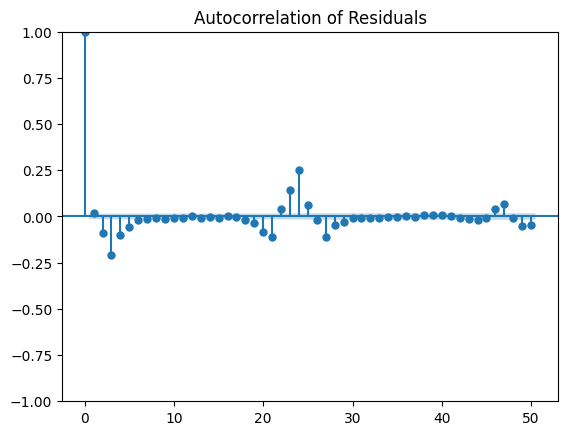

Ljung-Box test results:
        lb_stat      lb_pvalue
10  1108.065043  9.633942e-232


In [19]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract residuals from the fitted model
residuals = ucm_results.resid

# 1. Plot residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals from UCM Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

# 2. Plot histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='green')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.show()

# 3. Generate a QQ-plot to check for normality
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

# 4. Plot the autocorrelation function (ACF) of the residuals
sm.graphics.tsa.plot_acf(residuals, lags=50)
plt.title("Autocorrelation of Residuals")
plt.show()

# 5. Perform the Ljung-Box test to check for autocorrelation
# Testing up to lag 10 (you can adjust the number of lags as needed)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box test results:")
print(lb_test)

The Ljung-Box test indicates that the residuals from your model exhibit significant autocorrelation (with a p-value near zero), which suggests that the current model is not fully capturing all the serial dependencies in your data. In other words, there is remaining structure in the residuals that the model has not accounted for.

In [20]:
import numpy as np
import pandas as pd

# Assume non_missing_data is your DataFrame and "X" is your variable of interest.
# If the dataset index is not a DatetimeIndex, create a simple RangeIndex:
if not isinstance(non_missing_data.index, pd.DatetimeIndex):
    time_index = pd.RangeIndex(start=0, stop=len(non_missing_data), step=1)
else:
    time_index = non_missing_data.index

def create_fourier_terms(index, period, order):
    """
    Create Fourier terms (sine and cosine) for a given period and order.

    Parameters:
        index: The index for the time series (can be RangeIndex or DatetimeIndex).
        period: The seasonal period (e.g., 24 for daily seasonality in hourly data).
        order: The number of sine/cosine pairs to generate.

    Returns:
        A DataFrame with Fourier terms indexed the same as `index`.
    """
    t = np.arange(len(index))
    terms = {}
    for k in range(1, order + 1):
        terms[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        terms[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(terms, index=index)

# Create Fourier terms using the created time_index
fourier_terms = create_fourier_terms(time_index, period=24, order=3)


In [21]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Build the UCM model using Fourier terms for seasonality
ucm_model_fourier = UnobservedComponents(
    endog=non_missing_data["X"],
    level="local level",          # Local trend component
    stochastic_trend=True,
    irregular=True,               # Allow the irregular component
    seasonal=None,                # Do not use the built-in seasonal component
    exog=fourier_terms            # Include Fourier terms as exogenous regressors
)

# Fit the model
ucm_results_fourier = ucm_model_fourier.fit()
print(ucm_results_fourier.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `stochastic_trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


                        Unobserved Components Results                         
Dep. Variable:                      X   No. Observations:                16800
Model:                    local level   Log Likelihood               36155.121
Date:                Tue, 04 Feb 2025   AIC                         -72294.243
Time:                        15:46:17   BIC                         -72232.410
Sample:                             0   HQIC                        -72273.841
                              - 16800                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.758e-05   2.74e-06     10.060      0.000    2.22e-05    3.29e-05
sigma2.level         0.0007   7.33e-06    100.444      0.000       0.001       0.001
beta.sin_1           0.0262 

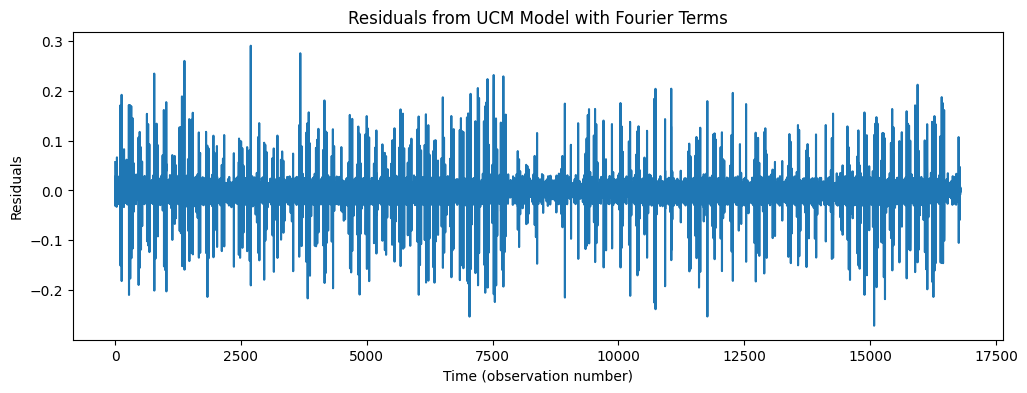

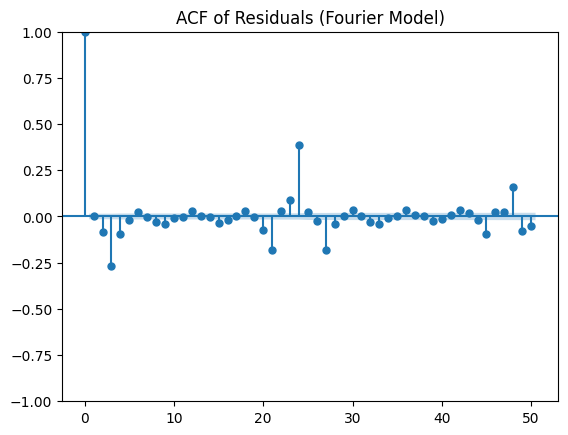

Ljung-Box test results for Fourier model:
        lb_stat  lb_pvalue
10  1541.268619        0.0


In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residual diagnostics
residuals_fourier = ucm_results_fourier.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals_fourier)
plt.title("Residuals from UCM Model with Fourier Terms")
plt.xlabel("Time (observation number)")
plt.ylabel("Residuals")
plt.show()

sm.graphics.tsa.plot_acf(residuals_fourier, lags=50)
plt.title("ACF of Residuals (Fourier Model)")
plt.show()

lb_test_fourier = acorr_ljungbox(residuals_fourier, lags=[10], return_df=True)
print("Ljung-Box test results for Fourier model:")
print(lb_test_fourier)


In [23]:
# Number of observations in your historical data
n_obs = len(non_missing_data)

# Create a future index for the next 744 time points
future_index = pd.RangeIndex(start=n_obs, stop=n_obs + 744, step=1)

# Re-use the create_fourier_terms function defined earlier
future_fourier_terms = create_fourier_terms(future_index, period=24, order=3)

# Forecast the next 744 steps using the future Fourier terms
ucm_forecast = ucm_results_fourier.get_forecast(steps=744, exog=future_fourier_terms)

forecast_output["UCM"] = ucm_forecast.predicted_mean.values

In [24]:
forecast_output

,DateTime,Date,Hour,X,X_filled,ARIMA,UCM,ML
16800,2016-12-01 00:00:00,2016-12-01,0,NaN,0.0099,0.006375,0.000374,None
16801,2016-12-01 01:00:00,2016-12-01,1,NaN,0.0099,0.004460,-0.005227,None
16802,2016-12-01 02:00:00,2016-12-01,2,NaN,0.0099,0.004701,-0.000620,None
16803,2016-12-01 03:00:00,2016-12-01,3,NaN,0.0099,0.008886,0.017375,None
16804,2016-12-01 04:00:00,2016-12-01,4,NaN,0.0099,0.020928,0.046243,None
...,...,...,...,...,...,...,...,...
17539,2016-12-31 19:00:00,2016-12-31,19,NaN,0.0099,0.015410,0.022056,None
17540,2016-12-31 20:00:00,2016-12-31,20,NaN,0.0099,0.013334,0.020922,None
17541,2016-12-31 21:00:00,2016-12-31,21,NaN,0.0099,0.012373,0.020508,None
17542,2016-12-31 22:00:00,2016-12-31,22,NaN,0.0099,0.009604,0.017318,None


# ML Model

In [25]:
import pandas as pd
import numpy as np

# Create features from DateTime
non_missing_data["hour"] = non_missing_data["DateTime"].dt.hour
non_missing_data["dayofweek"] = non_missing_data["DateTime"].dt.dayofweek
non_missing_data["month"] = non_missing_data["DateTime"].dt.month

# Create lag-based features (last 24 hours)
for lag in range(1, 25):
    non_missing_data[f"lag_{lag}"] = non_missing_data["X"].shift(lag)

# Create rolling statistics (mean & std over past 7 days)
non_missing_data["rolling_mean_7d"] = non_missing_data["X"].rolling(window=24*7).mean()
non_missing_data["rolling_std_7d"] = non_missing_data["X"].rolling(window=24*7).std()

# Drop rows with NaN values from lag features
non_missing_data = non_missing_data.dropna()


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define input features (excluding DateTime and target variable 'X')
feature_cols = ["hour", "dayofweek", "month"] + [f"lag_{i}" for i in range(1, 25)] + ["rolling_mean_7d", "rolling_std_7d"]

# Split data into training and validation sets
train_data, val_data = train_test_split(non_missing_data, test_size=0.1, shuffle=False)

X_train, y_train = train_data[feature_cols], train_data["X"]
X_val, y_val = val_data[feature_cols], val_data["X"]

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on validation set
val_predictions = xgb_model.predict(X_val)

# Evaluate model performance
mse_xgb = mean_squared_error(y_val, val_predictions)
print(f"Validation MSE (XGBoost): {mse_xgb:.4f}")


Validation MSE (XGBoost): 0.0004


In [27]:
import numpy as np

# Prepare the forecasting dataset
forecast_output["hour"] = forecast_output["DateTime"].dt.hour
forecast_output["dayofweek"] = forecast_output["DateTime"].dt.dayofweek
forecast_output["month"] = forecast_output["DateTime"].dt.month

# Initialize lags with the last known values
for lag in range(1, 25):
    forecast_output[f"lag_{lag}"] = np.nan  # Placeholder for lag values

# Rolling statistics placeholders
forecast_output["rolling_mean_7d"] = np.nan
forecast_output["rolling_std_7d"] = np.nan

# Start filling forecast step-by-step
predictions = []

for i in range(len(forecast_output)):
    # Extract the most recent available data
    last_known = non_missing_data.iloc[-24:].copy()  # Last day of actual data

    # Update lags with the last known value
    for lag in range(1, 25):
        if i - lag >= 0:
            forecast_output.loc[forecast_output.index[i], f"lag_{lag}"] = predictions[i - lag]
        else:
            forecast_output.loc[forecast_output.index[i], f"lag_{lag}"] = last_known["X"].iloc[-lag]

    # Compute rolling statistics dynamically
    forecast_output.loc[forecast_output.index[i], "rolling_mean_7d"] = last_known["X"].mean()
    forecast_output.loc[forecast_output.index[i], "rolling_std_7d"] = last_known["X"].std()

    # Prepare input features for XGBoost
    row_features = forecast_output.loc[forecast_output.index[i], feature_cols].values.reshape(1, -1)

    # Predict the next value using the trained XGBoost model
    next_prediction = xgb_model.predict(row_features)[0]
    predictions.append(next_prediction)

# Store the final predictions
forecast_output["ML"] = predictions

# Display the first few rows
print("Forecasted Data (XGBoost):")
print(forecast_output[["DateTime", "ML"]].head(10))


Forecasted Data (XGBoost):
                 DateTime        ML
16800 2016-12-01 00:00:00  0.006467
16801 2016-12-01 01:00:00  0.005696
16802 2016-12-01 02:00:00  0.005837
16803 2016-12-01 03:00:00  0.008353
16804 2016-12-01 04:00:00  0.017991
16805 2016-12-01 05:00:00  0.025874
16806 2016-12-01 06:00:00  0.045711
16807 2016-12-01 07:00:00  0.059477
16808 2016-12-01 08:00:00  0.077183
16809 2016-12-01 09:00:00  0.081180


In [28]:
display(forecast_output[['ML','ARIMA','UCM']])

,ML,ARIMA,UCM
16800,0.006467,0.006375,0.000374
16801,0.005696,0.004460,-0.005227
16802,0.005837,0.004701,-0.000620
16803,0.008353,0.008886,0.017375
16804,0.017991,0.020928,0.046243
...,...,...,...
17539,0.034530,0.015410,0.022056
17540,0.032123,0.013334,0.020922
17541,0.028352,0.012373,0.020508
17542,0.021786,0.009604,0.017318


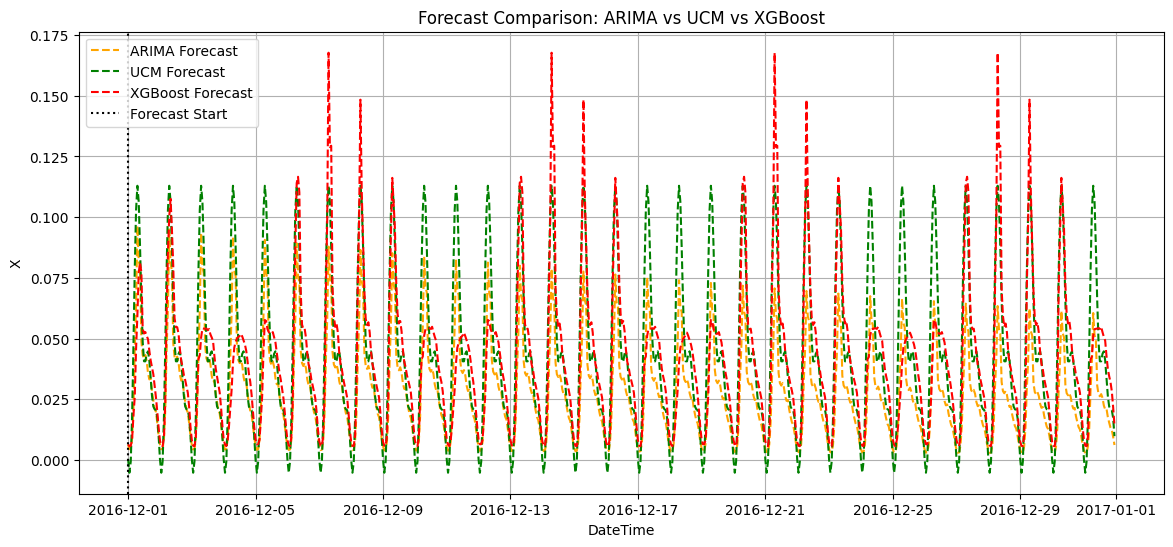

In [29]:
import matplotlib.pyplot as plt

# Plot historical data with all forecasts
plt.figure(figsize=(14, 6))

# ARIMA Forecast
plt.plot(forecast_output["DateTime"], forecast_output["ARIMA"], label="ARIMA Forecast", color="orange", linestyle="--")

# UCM Forecast
plt.plot(forecast_output["DateTime"], forecast_output["UCM"], label="UCM Forecast", color="green", linestyle="--")

# ML Forecast (XGBoost)
plt.plot(forecast_output["DateTime"], forecast_output["ML"], label="XGBoost Forecast", color="red", linestyle="--")

# Highlight Forecast Start
plt.axvline(x=forecast_output["DateTime"].min(), color="black", linestyle=":", label="Forecast Start")

# Formatting
plt.title("Forecast Comparison: ARIMA vs UCM vs XGBoost")
plt.xlabel("DateTime")
plt.ylabel("X")
plt.legend()
plt.grid()
plt.show()


In [30]:
# Select only the required columns
forecast_output_saved = forecast_output[["DateTime", "ARIMA", "UCM", "ML"]]

# Display the first few rows
print("Final Forecast Output:")
print(forecast_output_saved.head(10))

Final Forecast Output:
                 DateTime     ARIMA       UCM        ML
16800 2016-12-01 00:00:00  0.006375  0.000374  0.006467
16801 2016-12-01 01:00:00  0.004460 -0.005227  0.005696
16802 2016-12-01 02:00:00  0.004701 -0.000620  0.005837
16803 2016-12-01 03:00:00  0.008886  0.017375  0.008353
16804 2016-12-01 04:00:00  0.020928  0.046243  0.017991
16805 2016-12-01 05:00:00  0.045523  0.078096  0.025874
16806 2016-12-01 06:00:00  0.063719  0.102883  0.045711
16807 2016-12-01 07:00:00  0.096433  0.112909  0.059477
16808 2016-12-01 08:00:00  0.081912  0.106320  0.077183
16809 2016-12-01 09:00:00  0.079293  0.087741  0.081180


In [31]:
import os

# Create the directory if it doesn't exist
os.makedirs("/content/910235_05/02/", exist_ok=True)

# Now you can save the CSV file
forecast_output_saved.to_csv("/content/910235_05-02-2025.csv", index=False)